## CMSC 25025

## Homework 3

### Ruben Abbou

collab: Brendan Sanderson

### Problem 5: *Bernoulli mixtures for mnist*

In [22]:
import numpy as np, random
from numpy.linalg import svd, inv, eig, norm
from math import exp, log
import matplotlib.pyplot as plt
%matplotlib inline
data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))/255
numbers=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))

data = data[:1000]
data[data!=0]=1

L = len(data)
training = data[:int(.6*L)]
development = data[int(.6*L):int(.8*L)]
testing = data[int(.8*L):]
trainingn = numbers[:int(.6*L)]
developmentn = numbers[int(.6*L):int(.8*L)]
testingn = numbers[int(.8*L):]

In [16]:
def initialize_mixtures(X, y, M):
    mix = []
    for i in range(len(X)):
        mix.append(M * int(y[i]) + random.randint(0,M-1))
    return np.array(mix)
def probabilities(X, mixtures, M):
    p = []
    d = len(X.T)
    n = len(X)
    ind = []
    for j in range(d):
        pj = np.zeros(10*M)
        p.append(pj)
    for m in range(10*M):
        indices = [i for i, x in enumerate(mixtures) if x == m]
        ind.append(len(indices))
        for i in indices:
            for j in range(d):
                p[j][m] += X[i][j]
        for j in range(d):
            p[j][m] = (p[j][m]+1)/(len(indices)+2)
    return np.array(p)
def likelihood(xi, pim, pm):
    S = 0
    for j in range(len(xi)):
        S += xi[j]*log(pm[j]) + (1-xi[j])*log(1-pm[j])
    return S + log(pim)
def weights(X, p, pi, M):
    n = len(X)
    d = len(X.T)
    l = []
    for m in range(10*M):
        l_m = []
        for i in range(n):
            l_m.append(likelihood(X[i], pi[m], p.T[m]))
        l.append(l_m)
    l = np.array(l)
    w = []
    for m in range(10*M):
        w_m = []
        for i in range(n):
            L = max(l.T[i])
            sum_demon = sum([exp(lm - L) for lm in l.T[i]])
            w_m.append((exp(l[m][i] - L))/sum_demon)
        w.append(w_m)
    return np.array(w)
def fix_log(X, p, pi, M):
    S = 0
    n = len(X)
    for i in range(n):
        sum_log = 0
        for m in range(10*M):
            sum_log += exp(likelihood(X[i], pi[m], p.T[m]))
        S += log(sum_log)
    return S           
def iterations(X, p, pi, w, M):
    l = fix_log(test_data, p, pi, M)
    p, pi, w = m_step(X, p, pi, w, M)
    lnew = fix_log(test_data, p, pi, M)
    while (lnew-l > 10):
        l = lnew
        p, pi, w = m_step(X, p, pi, w, M)
        lnew = fix_log(test_data, p, pi, M)
    return p, pi, w
def e_step(X, mixtures, M):
    pi = np.zeros(M*10)
    for i in range(len(X)):
        pi[mixtures[i]] += 1
    pi = (pi+1)/(len(X)+2)

    p = []
    d = len(X.T)
    n = len(X)
    ind = []
    for j in range(d):
        pj = np.zeros(10*M)
        p.append(pj)
    for m in range(10*M):
        indices = [i for i, x in enumerate(mixtures) if x == m]
        ind.append(len(indices))
        for i in indices:
            for j in range(d):
                p[j][m] += X[i][j]
        for j in range(d):
            p[j][m] = (p[j][m]+1)/(len(indices)+2)
    p = np.array(p)
    
    w = weights(X, p, pi, M)
    return p, pi, w
def m_step(X, p, pi, w, M):
    n = len(X)
    d = len(X.T)
    for m in range(10*M):
        sumw = 0
        for i in range(n):
            sumw += w[m][i]
        pi[m] = (sumw+1) / (n+2)
    
    for j in range(d):
        for m in range(10*M):
            sumw = 0
            sumwx = 0
            for i in range(n):
                sumw += w[m][i]
                sumwx += w[m][i] * X[i][j]
        p[j][m] = (sumwx+1)/(sumw+2)
    w = weights(X, p, pi, M)
    return p, pi, w

def EM(X, Y, M):
    mixtures = initialize_mixtures(X, Y, M)
    p, pi, w = e_step(X, mixtures, M)
    if M>1:
        p, pi, w = iterations(X, p, pi, w, M)
    return p, pi

Since our sums are very small, we obtain a number very close to one when taking the exponential function of it. Using L therefore allows us to obtain a larger value and reduce the computer error.

### (e)

In [8]:
def plot_digits(means, nrows, ncols):
    plt.figure(figsize=(ncols, nrows))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(means.T[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
    plt.axis('off')
    plt.show()

In [4]:
model_1, pi_1 = EM(training, trainingn, 1)
model_3, pi_3 = EM(training, trainingn, 3)
model_5, pi_5 = EM(training, trainingn, 5)

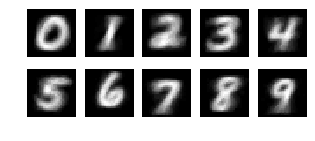

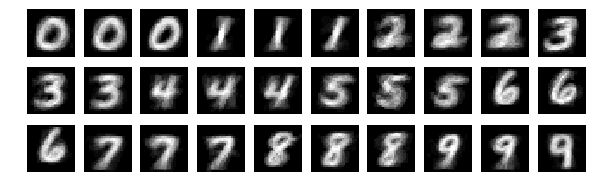

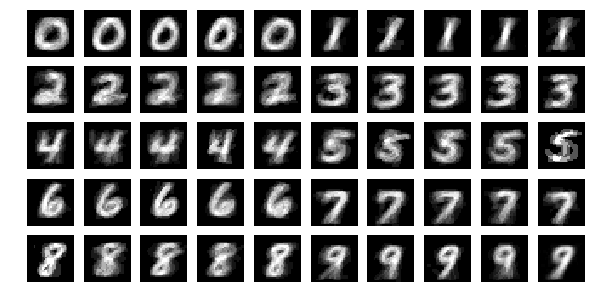

In [19]:
plot_digits(model_1, 2, 5)
plot_digits(model_3, 3, 10)
plot_digits(model_5, 5, 10)

We can see a very good clustering of each model in the mixture. Each image clearly corresponds to a digit, and the points seem to be well classified.

### (f)

In [27]:
def classify(X, p, pi, M): 
    c =[]
    for x in X:
        P = []
        d = len(x)
        for m in range(10*M):
            S = 0
            for j in range(d):
                S += x[j]*log(p[j][m]) + (1-x[j])*log(1-p[j][m])
            P.append(S)
        c_m = max(enumerate(P), key = lambda x: x[1])[0]
        c_mod = c_m % M
        lab = (c_m - c_mod)/M
        c.append(lab)
    return c

In [ ]:
c1 = classify(testing, model_1, pi_1, 1)
c3 = classify(testing, model_3, pi_3, 3)
c5 = classify(testing, model_5, pi_5, 5)

In [39]:
print("Error for M = 1 : %.2f" % np.mean([c1[i] != testingn[i] for i in range(len(c1))]))
print("Error for M = 3 : %.2f" % np.mean([c3[i] != testingn[i] for i in range(len(c1))]))
print("Error for M = 5 : %.2f" % np.mean([c5[i] != testingn[i] for i in range(len(c1))]))

Error for M = 1 : 0.21
Error for M = 3 : 0.20
Error for M = 5 : 0.23
